Using correlation for the removal of reverberation. At the moment we are using two mics at either end of the mic array with about 1 metre between them.

In [1]:
%matplotlib inline

In [2]:
import pywt
from librosa.core import load
from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter

from utils import apply_reverb, read_wav
import corpus
import mir_eval

from beta_ntf_np import beta_NTF

Load the files and if using a non mic array simulate it.

In [3]:
s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

y1, y2 = apply_reverb(s1, source_pos = [4, 4, 1.6])
y3, y4 = apply_reverb(s2, source_pos = [2, 4, 1.6])
sr = 16000
sr = 16000

/home/tinus/.virtualenvs/general_python2/local/lib/python2.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [4]:
bss = mir_eval.separation.bss_eval_sources(np.vstack((s1,s1)), np.vstack((y1,s1)))
print("SAR: {}".format(bss[2][0]))
print("SDR: {}".format(bss[0][0]))
print("SIR: {}".format(bss[1][0]))

/home/tinus/.virtualenvs/general_python2/local/lib/python2.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


SAR: 3.60596142971
SDR: 3.60596142971
SIR: 251.256096726


In [5]:
nfft=2048
win = 1024
hop = nfft/8

S1 = stft(s1, n_fft=nfft, hop_length=hop, win_length=win)
S2 = stft(s2, n_fft=nfft, hop_length=hop, win_length=win)
Y1 = stft(y1, n_fft=nfft, hop_length=hop, win_length=win)
Y2 = stft(y2, n_fft=nfft, hop_length=hop, win_length=win)
Y3 = stft(y3, n_fft=nfft, hop_length=hop, win_length=win)
Y4 = stft(y4, n_fft=nfft, hop_length=hop, win_length=win)

In [35]:
I = 2
J = 2
IJ = I * J
F, T = Y1.shape
X = np.asarray([Y1+Y3, Y2+Y4])
# K_partition = np.asarray([20,20])
# K_partition = np.asarray([50,50])
K_partition = np.asarray([100,100])
# K_partition = np.asarray([150,150])
K = np.sum(K_partition)
print(X.shape)
mix_psd = 0.5 * (np.mean(np.power(np.abs(X[0,:,:]),2) + np.power(np.abs(X[1,:,:]),2),axis=1))
mix_psd = mix_psd.reshape((-1, 1))

A = 0.5 * np.multiply(1.9 * np.abs(np.random.randn(I,IJ,F)) + 0.1 * np.ones((I,IJ,F)),np.sign(np.random.randn(I,IJ,F) + 1j *np.random.randn(I,IJ,F)))
W = 0.5 * np.multiply(np.abs(np.random.randn(F,K)) + np.ones((F,K)), np.matmul(mix_psd, np.ones((1,K))))
H = 0.5 * np.abs(np.random.randn(K,T)) + np.ones((K,T))
Q = 0.5 * np.abs(np.random.randn(J,K)) + np.ones((J,K))
sigma_b = mix_psd / 100

QoH = np.zeros((J, T, K))
for k in range(K):
    Q_k = Q[:,k].reshape((-1, 1))
    H_k = H[k,:].reshape((1,-1))
    QoH[:,:,k] = np.matmul(Q_k, H_k)

V = np.zeros((J, F, T))
for j in range(J):
    V[j, :, :] = np.matmul(W, QoH[j,:,:].reshape((K, T)))

(2, 1025, 183)


(0.011795846658770742+0j)


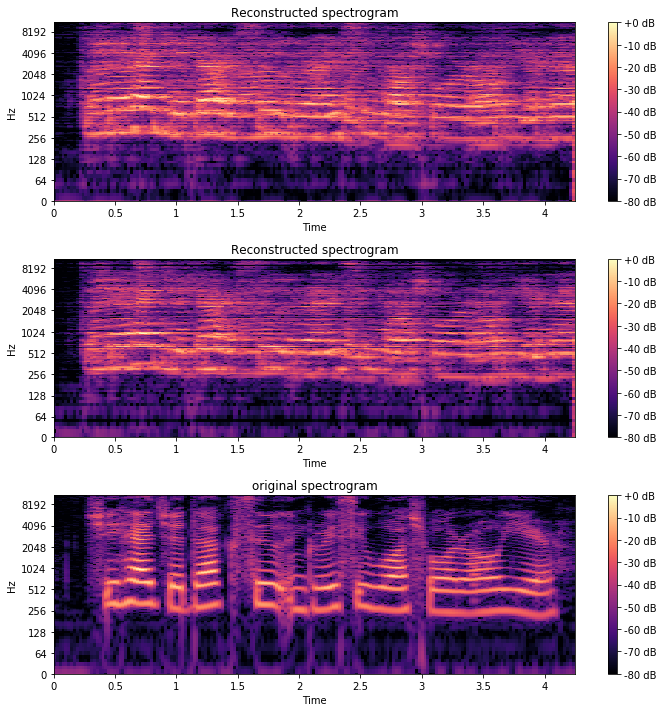

In [36]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=100)
bn.train()
Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

plot the spectogram for the reconstructed and original signals

(0.011920840443729108+0j)


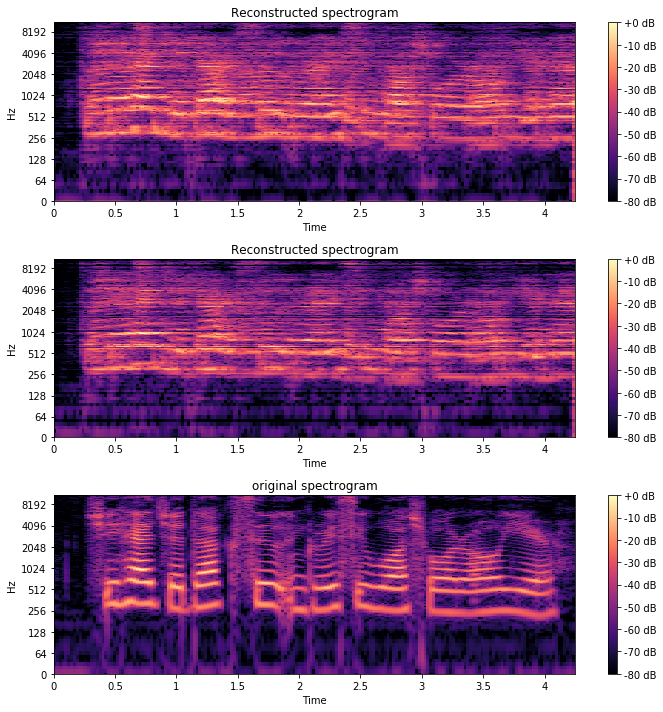

In [37]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=200)
bn.train()
Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

(0.011970787145449774+0j)


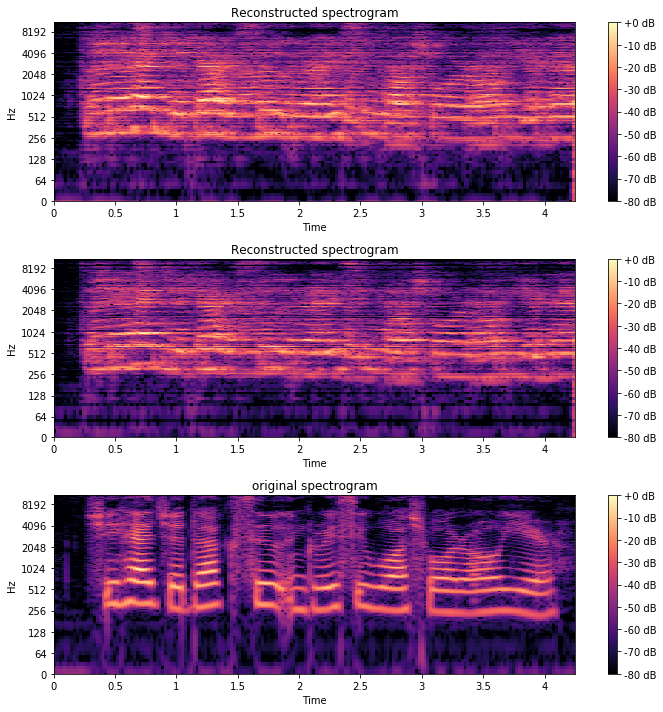

In [38]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=300)
bn.train()
Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

(0.011994225873949976+0j)


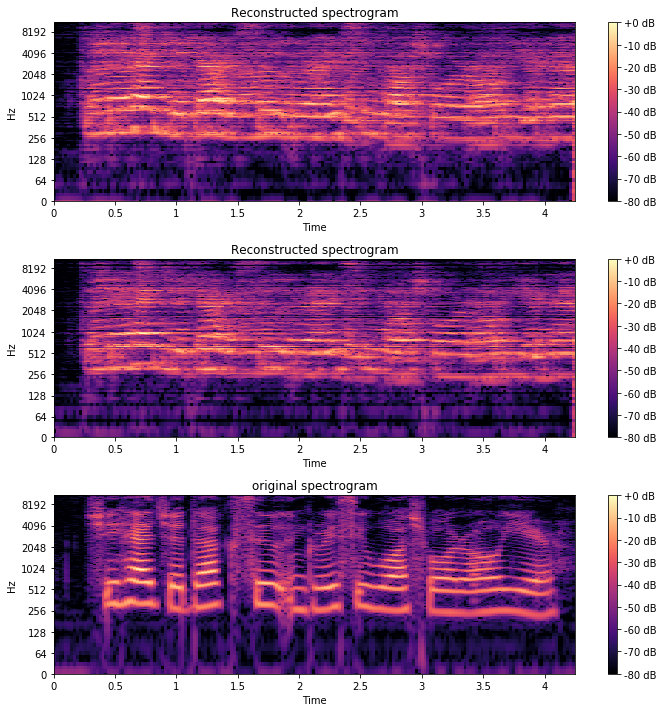

In [39]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=400)
bn.train()
Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

(nan+nanj)


IndexError: cannot do a non-empty take from an empty axes.

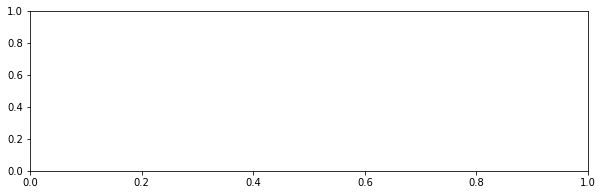

In [40]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=500)
bn.train()
Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.subplot(313, sharex=ax1)
specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
plt.title('original spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Do the ISTFT on the reconstructed wavelet

In [11]:
recon_y1_0 = istft(X[0])
recon_y1_1 = istft(X[1])

Plot the signal orange original and blue reconstructed. Change the voltage on the reconstructed signal in such a way that it is in the same range as the original signal.

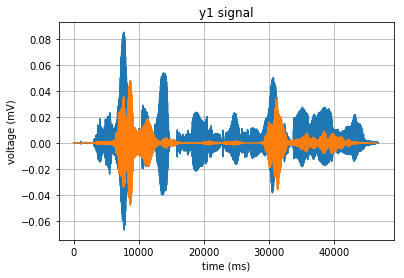

In [12]:
divider_0 = max(recon_y1_0)/max(y1)

fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_0/divider_0)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()
write_wav('file_removed_reverb_NMF0.wav', recon_y1_0/divider_0, sr)

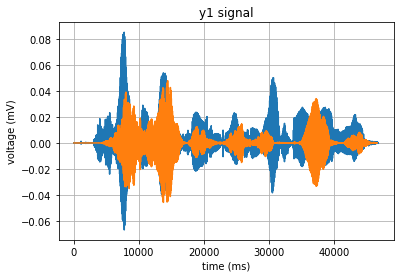

In [13]:
divider_1 = max(recon_y1_1)/max(y1)

fig, ax = plt.subplots()
ax.plot(s1)
ax.plot(recon_y1_1/divider_1)


ax.set(xlabel='time (ms)', ylabel='voltage (mV)',
       title='y1 signal')
ax.grid()
write_wav('file_removed_reverb_NMF1.wav', recon_y1_1/divider_1, sr)

Amplitude of the reconstructed (orange) and original (blue) signal

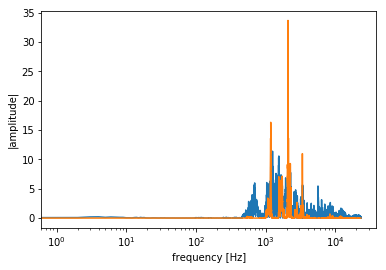

In [14]:
fig, ax = plt.subplots()
ampl_ry1 = abs(np.fft.rfft(recon_y1_0)/divider_0)
# ampl_ry1[:700] = 0
ampl_y1 = abs(np.fft.rfft(y1))
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('|amplitude|')
plt.plot(ampl_y1)
plt.plot(ampl_ry1)


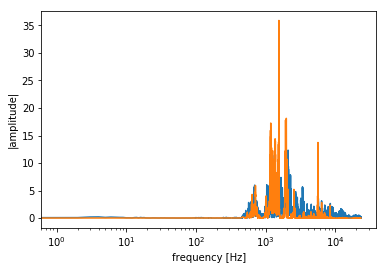

In [15]:
fig, ax = plt.subplots()
ampl_ry1 = abs(np.fft.rfft(recon_y1_1)/divider_1)
# ampl_ry1[:700] = 0
ampl_y1 = abs(np.fft.rfft(y1))
ax.set_xscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('|amplitude|')
plt.plot(ampl_y1)
plt.plot(ampl_ry1)

In [16]:
bss = mir_eval.separation.bss_eval_sources(np.vstack((s1,s1)), np.vstack((y1,s1)))
print("SAR: {}".format(bss[2][0]))
print("SDR: {}".format(bss[0][0]))
print("SIR: {}".format(bss[1][0]))
last_index = s1.shape[0] - recon_y1_0.shape[0]
print(last_index)
if last_index < 0:
    print("Reconstructed X0")
    bss = mir_eval.separation.bss_eval_sources(np.vstack((s1,s1)), np.vstack((recon_y1_0[:last_index]/divider_0,s1)))
    print("SAR: {}".format(bss[2][0]))
    print("SDR: {}".format(bss[0][0]))
    print("SIR: {}".format(bss[1][0]))
    print("Reconstructed X1")
    bss = mir_eval.separation.bss_eval_sources(np.vstack((s1,s1)), np.vstack((recon_y1_1[:last_index]/divider_1,s1)))
    print("SAR: {}".format(bss[2][0]))
    print("SDR: {}".format(bss[0][0]))
    print("SIR: {}".format(bss[1][0]))
else:
    s1_2 = s1[:-last_index]
    print("Reconstructed X0")
    bss = mir_eval.separation.bss_eval_sources(np.vstack((s1_2,s1_2)), np.vstack((recon_y1_0/divider_0,s1_2)))
    print("SAR: {}".format(bss[2][0]))
    print("SDR: {}".format(bss[0][0]))
    print("SIR: {}".format(bss[1][0]))
    print("Reconstructed X1")
    bss = mir_eval.separation.bss_eval_sources(np.vstack((s1_2,s1_2)), np.vstack((recon_y1_1/divider_1,s1_2)))
    print("SAR: {}".format(bss[2][0]))
    print("SDR: {}".format(bss[0][0]))
    print("SIR: {}".format(bss[1][0]))
    

SAR: 3.60596142971
SDR: 3.60596142971
SIR: 251.256096726
205
Reconstructed X0
SAR: -5.71077776751
SDR: -5.71077776751
SIR: 234.440317042
Reconstructed X1
SAR: -4.50866540463
SDR: -4.50866540463
SIR: 236.799224415
